In [21]:
%matplotlib inline

In [22]:
# needed libraries
import warnings
warnings.simplefilter("ignore")

import numpy as np

from IPython.display import display, clear_output

import math
import numpy
import scipy
import cmath
import time
import pandas as pd

from scipy import integrate

import matplotlib.pyplot as plt

import ipywidgets as widgets

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)



In [23]:
# A) Initialisation des variables  

# 1. Constantes physiques (NIST)
h    = 6.626068e-34  # [J.S]      Planck constant
heV  = 4.135667e-15  # [eV.s]     Planck constant
hb   = h/(2*math.pi)      # [J.s]      h barre
hbeV = heV/(2*math.pi)    # [eV.s]     h barre
me   = 9.109381e-31  # [kg]       electron mass
q    = 1.6021764e-19 # [C]        electron charge
c    = 299792458     # [m.s^(-1)] speed of light in vacuum

# 2. Propriété de la particule étudiée
m = 0.1*me  # [kg] masse (me = masse de l'électron)
a  = 5e-9   #    extension spatiale du paquet d'onde                        
x0 = -60e-9 # position centrale du pic de probabilité
                              
# 3. Propriétés de l'espace étudié (puits, maille,...)
xMIN = -100e-9 # [m] extension maximale vers la gauche
xMAX = -xMIN   # [m] extension maximale vers la droite
xNum = 601     #  [-] nombre de valeurs discrétisées de x (résolution) doit être impair
max_iter = xNum/2    # nombre d'iterations pas pas de dt

# 5 Définitions de constantes internes
dx    = (xMAX-xMIN)/(xNum-1) # [m]
xArr  = numpy.linspace(xMIN, xMAX, xNum-1)
xOnes = [1.0] * (xNum-1)


Choix du potentiel
 1. Marche
 2. Barrière finie centrée sur x = 0
 3. Double barrières finies centrées sur x = 0
 4. Potentiel plat
Entrez un nombre de 1 à 4: 2
 2. Barrière finie centrée sur x = 0
Hauteur de la barrière (eV) = 0.2
Largeur de la barrière (en nm, max 50 nm)= 20


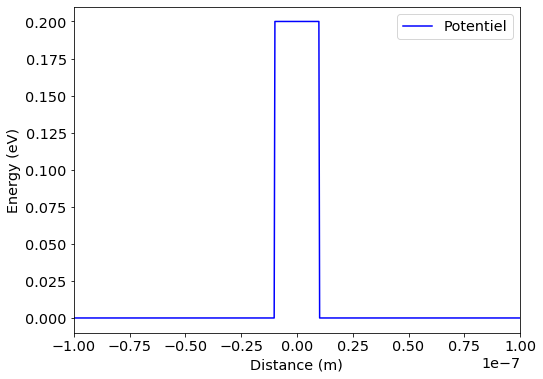

In [24]:
 ####################################################################################

#% 1. Choix du potentiel
print('Choix du potentiel')
print(' 1. Marche')
print(' 2. Barrière finie centrée sur x = 0')
print(' 3. Double barrières finies centrées sur x = 0')
print(' 4. Potentiel plat')


idxPot = 1
idxPot = int(input("Entrez un nombre de 1 à 4: ")) 

# definition du potentiel
if idxPot==1:
    print(' 1. Marche')
    PotMAX = float(input('Hauteur de la marche (eV) = '))
    PotMAX = PotMAX*q
    Pot1 = [-PotMAX/2] * int((xNum-1)/2)
    Pot2 = [PotMAX/2] * int((xNum-1)/2)
    Pot = Pot1 + Pot2
elif idxPot==2:
    print(' 2. Barrière finie centrée sur x = 0')
    PotMAX = float(input('Hauteur de la barrière (eV) = '))
    PotMAX = PotMAX*q
    Width = float(input('Largeur de la barrière (en nm, max 50 nm)= '))
    Width = Width*1e-9
    Pot = []
    for ii, xx in enumerate(xArr):
        if (xx <= - Width/2) or (xx >= Width/2):
            Pot.append(0.0)
        else:
            Pot.append(PotMAX)
elif idxPot==3:
    print(' 3. Double barrières finies centrées sur x = 0')
    PotMAX = float(input('Hauteur des barrières (eV) = '))
    PotMAX = PotMAX*q
    Width = float(input('Largeur des barrières (en nm, max 25 nm)= '))
    Width2 = float(input('Ecart entre les barrières (en nm, max 20 nm)= '))
    Width = Width*1e-9
    Width2 = Width2*1e-9
    Pot = []
    for ii, xx in enumerate(xArr):
        if (xx <= -(Width+Width2)/2) or (xx > -Width2/2) and (xx < Width2/2) or (xx >= (Width+Width2)/2):
            Pot.append(0.0)
        else:
            Pot.append(PotMAX)   
else: 
    print(' 4. Plat (= puits infini) -- default choice')
    PotMAX = 0.3*q
    Pot = [0.0] * int(xNum-1)

    
# affichage du potentiel
plt.plot(xArr,numpy.array(Pot)/q,label='Potentiel', color='b')
plt.legend(fontsize='x-large')
plt.yticks(color='k', size='x-large')
plt.xticks(color='k', size='x-large') 
plt.ylabel('Energy (eV)',fontsize='x-large')
plt.xlabel('Distance (m)',fontsize='x-large')
plt.xlim((xMIN,xMAX))
plt.show()



In [26]:
energie_p = float(input('Energie de particule (rapport de la hauteur du potentiel ) :'))
on_off=True

def Schroedinger_Dep(energie_p,PotMAX,Pot,on_off):
    """"Args:  
            - energie_p: énergie de la particule 
            - PotMAX: hauteur, 
            - Pot: potential, 
            - on_off: calcule les matrices M et L
          Return:
            - n_Psi2_norm_list: la fonction d'onde normée"""

    #énergie de la particule
    E = energie_p*PotMAX
    # Fonction d'onde
    k0 = math.sqrt(2*m*E)/hb  #  nombre d'onde moyen
    # fonction d'onde
    Psi = [ (cmath.exp(1j*xx*k0) * cmath.exp(-((xx-x0)/a)**2)) for xx in xArr]
    Psi = numpy.array(Psi)
    # norme de la fonction d'onde = densité
    Psi2 = numpy.conj(Psi)*Psi
    # intégration de la densité 
    
    Psi_int = integrate.simps(Psi2, x=xArr)
    # normalistation de la densité
    Psi2_norm = Psi2 / Psi_int.real
    PSIMAX = max(Psi2_norm.real)
   
    # 4. Déplacement du paquet d'onde
    #  Quelques variables
    vg   = hb*k0/m       # [m.s^(-1)] vitesse de groupe
    tMAX = 3*abs(x0)/vg  # [s]        temps total = 3 fois le tps nécessaire pour parcourir x0 à la vitesse vg
    tNum = 1*abs(x0)/dx  # nombre de valeurs discrétisées de t 
    dt   = tMAX/(tNum-1) # [s]
  
    
    n_Psi2_norm_list = [Psi2_norm/PSIMAX]*xNum
    
    
    if on_off==True:
        #  Definition des matrices M et L
        n_Psi2_norm_list = []
        CI = 4*m*(dx**2)/(hb*dt)
        CR = 2*m*(dx**2)/(hb**2)
        diagM     = 1j*CI - ( CR * numpy.array(Pot) + 2)
        diagL     = 1j*CI + ( CR * numpy.array(Pot) + 2)
        diag1 = [1.0] * int(xNum-2)
        diag2 = [-1.0] * int(xNum-2)
   
        matM = numpy.diag(diagM,k=0) + numpy.diag(diag1,k=1) + numpy.diag(diag1,k=-1)
        matL = numpy.diag(diagL,k=0) + numpy.diag(diag2,k=1) + numpy.diag(diag2,k=-1)
       
        matM_inv = numpy.linalg.inv(matM)

        n_Psi = Psi
        for ii in numpy.arange(1,max_iter):
            n_Psi     = numpy.dot(numpy.dot(matM_inv,matL),n_Psi) # nouvelle fonction d'onde
            n_Psi2    = numpy.conj(n_Psi)*n_Psi #  Distribution de probabilité
            n_Psi_int   = integrate.simps(n_Psi2, x=xArr) # intégration de Simpsons
            n_Psi2_norm = n_Psi2 / n_Psi_int.real # normalisation
            n_Psi2_norm_list.append(n_Psi2_norm/PSIMAX)
 
    return n_Psi2_norm_list
 
# calcule l'évolution de la fonction d'onde
n_Psi2_norm_list = Schroedinger_Dep(energie_p,PotMAX,Pot,on_off)

dataframe = pd.DataFrame(n_Psi2_norm_list)
dataframe = dataframe.transpose()
dataframe['xArr'] = xArr

Energie de particule (rapport de la hauteur du potentiel ) :0.5


In [27]:
# Affichage de l'évolution de la fonction d'onde

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for index in dataframe.index[0:dataframe.shape[1]-1]:
    ax.cla()
    ax.plot(xArr,numpy.array(Pot)/q,label='Potentiel', color='b')
    ax.plot(dataframe['xArr'],n_Psi2_norm_list[index], color='g')
    ax.set_ylim((0,1))
    ax.set_ylabel('Densité de probabilité',fontsize='x-large')
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.02)

    


    

KeyboardInterrupt: 